In [116]:
%matplotlib inline

import glob
import uproot
import pprint
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams['text.usetex'] = True
lw = 2
xyLabelFontSize = 20
xLabelPad = 10
yLabelPad = 15

pp = pprint.PrettyPrinter()
folder = '/ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5'
files = glob.glob(f"{folder}" + "/**/*.root", recursive=True)
files = [file for file in files if "DYJetsToLL_M-50" in file]

files = [file + ':taus' for file in files if "taus" in file or "jets" in file]
pp.pprint(files)


#testfile = f'{folder}/DYJetsToLL_M-50_taus.root:taus'

ttree = uproot.open(files[0])
print("")

pp.pprint(f'keys: {ttree.keys()}')
print("")

#pp.pprint(f'values: {ttree.values()}')
print("")

pp.pprint(ttree.show())

['/ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/DYJetsToLL_M-50_taus.root:taus',
 '/ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/DYJetsToLL_M-50_jets.root:taus']

("keys: ['pfCand_mass', 'pfCand_particleType', 'pfCand_puppiWeightNoLep', "
 "'pfCand_pt', 'pfCand_charge', 'pfCand_deltaR', 'pfCand_phi', 'pfCand_eta', "
 "'pfCand_jetDaughter', 'pfCand_deltaPhi', 'pfCand_deltaEta']")


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
pfCand_mass          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pfCand_particleType  | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
pfCand_puppiWeigh... | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pfCand_pt            | std::vector<

pfCand_deltaPhi = ttree['pfCand_deltaPhi'].array()
nNodes = np.array([len(x) for x in pfCand_deltaPhi])
nEdges = np.array([x*(x-1) for x in nNodes])
pfCand_deltaPhi = ak.flatten(pfCand_deltaPhi, axis=None)
pfCand_deltaEta = ak.flatten(ttree['pfCand_deltaEta'].array(), axis=None)
pfCand_deltaR = ak.flatten(ttree['pfCand_deltaR'].array(), axis=None)
pfCand_pt = ak.flatten(ttree['pfCand_pt'].array(), axis=None)
pfCand_mass = ak.flatten(ttree['pfCand_mass'].array(), axis=None)

print(f'graph count: {len(nNodes)}')

print(f'Max node count: {max(nNodes)}')
print(f'Min node count: {min(nNodes)}')

print(f'Max edge count: {max(nEdges)}')
print(f'Min edge count: {min(nEdges)}')

In [6]:
def getBinsByPercentile(arrayDict, nBins, maxPercentile=99):
    minVal = 999999999999
    maxVal = -999999999999
    for arr in arrayDict.values():
        p = np.percentile(arr, [0, maxPercentile])
        minVal = p[0] if p[0] < minVal else minVal
        maxVal = p[1] if p[1] > maxVal else maxVal
    binWidth = (maxVal - minVal) / nBins
    
    while(binWidth.is_integer() == False):
        maxVal += 1
        binWidth = (maxVal-minVal) / nBins
    
    return np.linspace(minVal, maxVal, nBins+1)

In [7]:
nBins = 25
baseFileName = "DYJetsToLL_M-50_puppiAndDeltaRCut"
tree = { "Genuine taus" : uproot.open(files[0]), "Jets" : uproot.open(files[0])}
genuine = uproot.open(files[0])
jets = uproot.open(files[1])

pfCand_deltaPhi = {
    "Genuine taus" : genuine["pfCand_deltaPhi"].array(),
    "Jets" : jets["pfCand_deltaPhi"].array()
}

nNodes = {
    "Genuine taus" : np.array([len(x) for x in pfCand_deltaPhi["Genuine taus"]]),
    "Jets" : np.array([len(x) for x in pfCand_deltaPhi["Jets"]])
}

nEdges = {
    "Genuine taus" : np.array([x*(x-1) for x in nNodes["Genuine taus"]]),
    "Jets" : np.array([x*(x-1) for x in nNodes["Jets"]])
}

pfCand_deltaPhi = {
    "Genuine taus" : ak.to_numpy(ak.flatten(genuine["pfCand_deltaPhi"].array(), axis=None)),
    "Jets" : ak.to_numpy(ak.flatten(jets["pfCand_deltaPhi"].array(), axis=None))
}

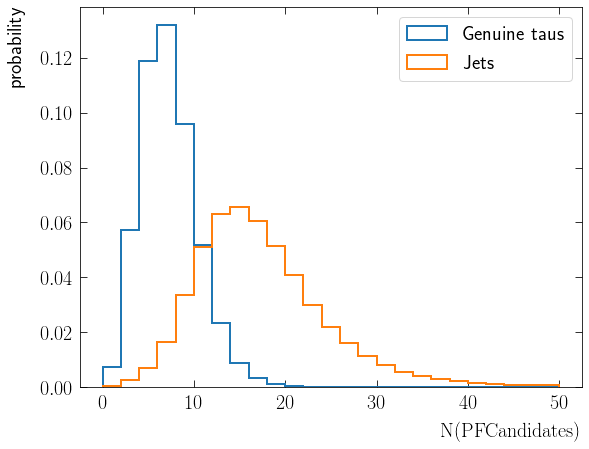

In [173]:
bins = getBinsByPercentile(nNodes, nBins)

fig, ax = plt.subplots(figsize=(9,7))
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
               bottom=True, top=True, left=True, right=True, length=7, pad=7, which='major')

ax.hist(nNodes["Genuine taus"], bins=bins, label="Genuine taus", histtype="step", linewidth=lw, density=True)
ax.hist(nNodes["Jets"], bins=bins, label="Jets", histtype="step", linewidth=lw, density=True)
ax.set_xlabel(r"$\mathrm{N(PFCandidates)}$", loc='right', labelpad=xLabelPad, fontsize=xyLabelFontSize)
ax.set_ylabel("probability", loc='top', labelpad=yLabelPad, fontsize=xyLabelFontSize)
ax.legend()
plt.savefig(f'{baseFileName}_NodeCount.png')
plt.show()

[   0.   48.   96.  144.  192.  240.  288.  336.  384.  432.  480.  528.
  576.  624.  672.  720.  768.  816.  864.  912.  960. 1008. 1056. 1104.
 1152. 1200.]
26


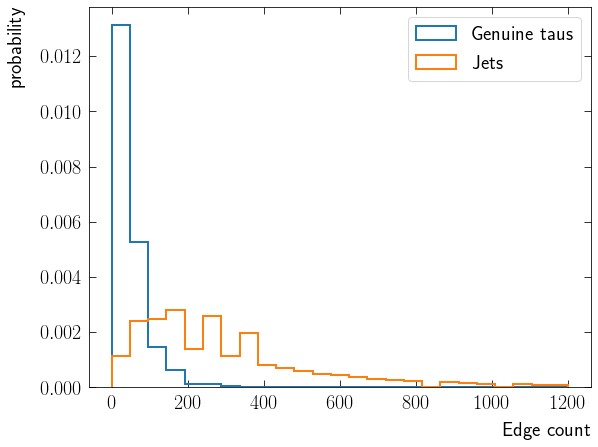

In [174]:
bins = getBinsByPercentile(nEdges, nBins, 99)
bins = np.linspace(0, 1200, 26)
#bins = 'auto'
print(bins)
print(len(bins))

fig, ax = plt.subplots(figsize=(9,7))
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
               bottom=True, top=True, left=True, right=True, length=7, pad=7, which='major')

ax.hist(nEdges["Genuine taus"], bins=bins, range=(0,1200),label="Genuine taus", histtype="step", linewidth=lw, density=True)
ax.hist(nEdges["Jets"], bins=bins, range=(0,1200), label="Jets", histtype="step", linewidth=lw, density=True)
ax.set_xlabel("Edge count", loc='right', labelpad=xLabelPad, fontsize=xyLabelFontSize)
ax.set_ylabel("probability", loc='top', labelpad=yLabelPad, fontsize=xyLabelFontSize)
ax.legend()
plt.savefig(f'{baseFileName}_EdgeCount.png')
plt.show()

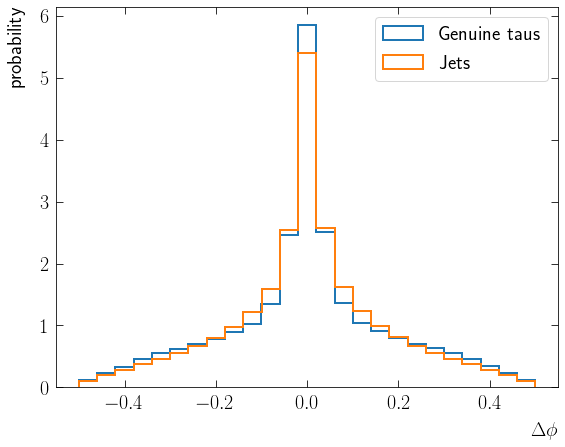

In [168]:
fig, ax = plt.subplots(figsize=(9,7))
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
               bottom=True, top=True, left=True, right=True, length=7, pad=7, which='major')

ax.hist(pfCand_deltaPhi["Genuine taus"], bins=nBins, label="Genuine taus", histtype="step", linewidth=lw, density=True)
ax.hist(pfCand_deltaPhi["Jets"], bins=nBins, label="Jets", histtype="step", linewidth=lw, density=True)
ax.set_xlabel("$\Delta \phi$", loc='right', labelpad=xLabelPad, fontsize=xyLabelFontSize)
ax.set_ylabel("probability", loc='top', labelpad=yLabelPad, fontsize=xyLabelFontSize)
ax.legend()
plt.savefig(f'{baseFileName}_pfCand_deltaPhi.png')
plt.show()

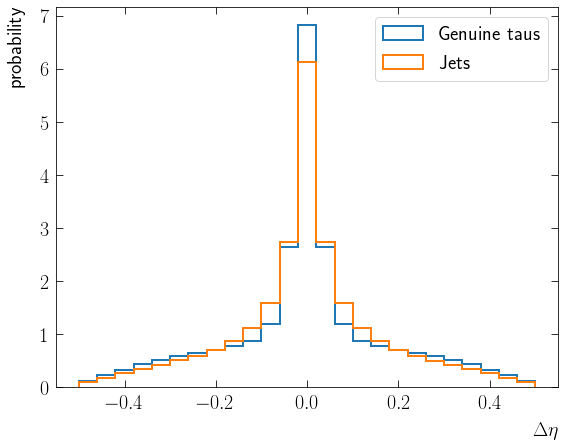

In [169]:
pfCand_deltaEta = {
    "Genuine taus" : ak.to_numpy(ak.flatten(genuine["pfCand_deltaEta"].array(), axis=None)),
    "Jets" : ak.to_numpy(ak.flatten(jets["pfCand_deltaEta"].array(), axis=None))
}

fig, ax = plt.subplots(figsize=(9,7))
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
               bottom=True, top=True, left=True, right=True, length=7, pad=7, which='major')
#ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
#               bottom=True, top=True, left=True, right=True, length=3, which='minor')
#ax.minorticks_on()

ax.hist(pfCand_deltaEta["Genuine taus"], bins=nBins, label="Genuine taus", histtype="step", linewidth=lw, density=True)
ax.hist(pfCand_deltaEta["Jets"], bins=nBins, label="Jets", histtype="step", linewidth=lw, density=True)
ax.set_xlabel("$\Delta \eta$", loc='right', labelpad=xLabelPad, fontsize=xyLabelFontSize)
ax.set_ylabel("probability", loc='top', labelpad=yLabelPad, fontsize=xyLabelFontSize)
ax.legend()
plt.savefig(f'{baseFileName}_pfCand_deltaEta.png')
plt.show()

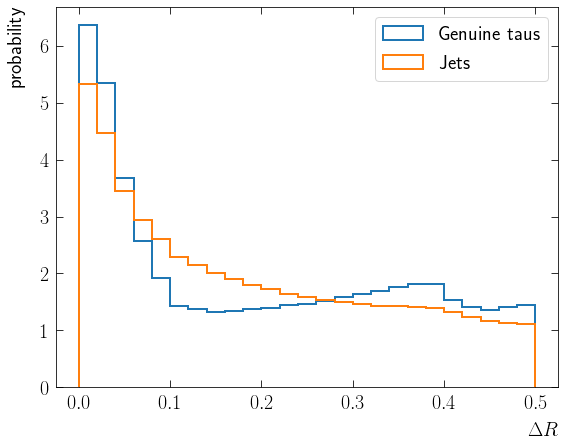

In [170]:
pfCand_deltaR = {
    "Genuine taus" : ak.to_numpy(ak.flatten(genuine["pfCand_deltaR"].array(), axis=None)),
    "Jets" : ak.to_numpy(ak.flatten(jets["pfCand_deltaR"].array(), axis=None))
}

fig, ax = plt.subplots(figsize=(9,7))
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
               bottom=True, top=True, left=True, right=True, length=7, pad=7)

ax.hist(pfCand_deltaR["Genuine taus"], bins=nBins, label="Genuine taus", histtype="step", linewidth=lw, density=True)
ax.hist(pfCand_deltaR["Jets"], bins=nBins, label="Jets", histtype="step", linewidth=lw, density=True)
ax.set_xlabel("$\Delta R$", loc='right', labelpad=xLabelPad, fontsize=xyLabelFontSize)
ax.set_ylabel("probability", loc='top', labelpad=yLabelPad, fontsize=xyLabelFontSize)
ax.legend()
plt.savefig(f'{baseFileName}_pfCand_deltaR.png')
plt.show()

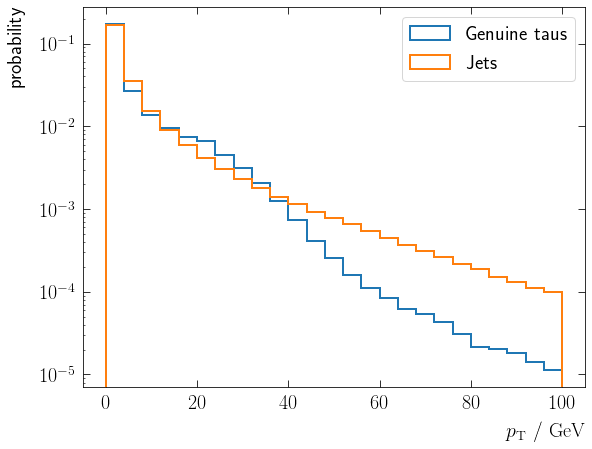

In [176]:
pfCand_pt = {
    "Genuine taus" : ak.to_numpy(ak.flatten(genuine["pfCand_pt"].array(), axis=None)),
    "Jets" : ak.to_numpy(ak.flatten(jets["pfCand_pt"].array(), axis=None))
}


fig, ax = plt.subplots(figsize=(9,7))
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
               bottom=True, top=True, left=True, right=True, length=7, pad=7)

ax.hist(pfCand_pt["Genuine taus"], bins=nBins, range=(0, 100), label="Genuine taus", log=True,histtype="step", linewidth=lw, density=True)
ax.hist(pfCand_pt["Jets"], bins=nBins, range=(0, 100), label="Jets", histtype="step", log=True, linewidth=lw, density=True)
ax.set_xlabel("$p_{\mathrm{T}}\,\,/ \,\, \mathrm{GeV}$", loc='right', labelpad=xLabelPad, fontsize=xyLabelFontSize)
ax.set_ylabel("probability", loc='top', labelpad=yLabelPad, fontsize=xyLabelFontSize)
ax.legend()
plt.savefig(f'{baseFileName}_pfCand_pt.png')
plt.show()

In [175]:
print(np.sum(pfCand_pt["Genuine taus"] * 4.0))

29875810.0
